In [39]:
import numpy as np
import matplotlib.pyplot as plt

In [40]:
def simulate_atlas(T, N, i, init_value, sigma, gamma, g):
    """
    simulate_atlas is a function that simulates the capital 
    distributions of stocks in a general Atlas model
    
    :param T: time interval
    :param N: number of points per path
    :param i: number of stocks simulated
    :param init_value: vector of initial values of stocks
    :param sigma: vector of volatilities of stocks
    :param gamma: base drift of stocks
    :param g: vector of drifts of stocks
    
    :return: vector of capital distributions of stocks sorted by rank
    """
    
    X = np.empty((i, N))
    X[:,0] = init_value
    drifts = np.add(gamma, g)
    dt = T/N

    for t in range(1, N):
        arr = X[:, t-1]
        order = arr.argsort()
        ranks = order[::-1].argsort()
        Zn = np.multiply(np.sqrt(dt), np.random.randn(i))
        
        X[:,t] = np.add( np.add(X[:,t-1], np.multiply(dt, drifts[ranks])), np.multiply(Zn, sigma[ranks]))
        # X[:,t-1] + dt * drifts[ranks] + sqrt(dt) * Z * sigma(ranks)

    return np.exp(X)

In [41]:
def generate_init_values(i, g, sigma, rand_value):
    """
    generate_init_values creates a vector of initial values based
    off of the limiting distribution of the capital distribution
    of stocks in the general Atlas model
    
    :param i: number of stocks simulated
    :param g: vector of drifts of stocks
    :param sigma: vector of volatilities of stocks
    :param rand_value: value of capital distribution of the weakest stock

    :return: vector of initial value of Atlas model stocks
    """

    init_value = np.empty(i)
    init_value[i-1] = rand_value
    for j in range(i-2, -1, -1):
        # Z ~ Exp((sum_{j=1}^k g_k) / (sigma_k^2 + sigma_{k+1}^2))
        Z = np.random.exponential( (sigma[j]^2 + sigma[j+1]^2) / (-4 * np.sum(g[:j+1])) )
        init_value[j] = np.exp(Z) * init_value[j+1]

    return np.log(init_value)


In [42]:
def discrete_excess_growth_rate(pi, delta, X, T, N):
    """
    discrete_excess_growth_rate calculates the discrete excess growth rate of
    a given portfolio and a given path traded at delta intervals of time

    :param pi: vector of portfolio weights
    :param delta: time interval over which the portfolio is rebalanced
    :param X: capital distribution of stocks
    :param T: time interval
    :param N: number of points per path
    :param i: number of stocks simulated

    :return: the average of the realized excess growth rate
    """
    excess = 0
    next_weights = np.divide(X[:,0], np.sum(X[:,0]))
    # print(next_weights)
    for t in range(delta, N, delta):
        # calculate the returns of each stock
        curr_weights = next_weights
        next_weights = np.divide(X[:,t], np.sum(X[:,t]))
        R = np.divide(next_weights, curr_weights)

        # print("curr_weights: ")
        # print(curr_weights)
        # print("next_weights: ")
        # print(next_weights)
        
        excess += np.log(np.sum(np.multiply(pi, R)))
        excess -= np.sum(np.multiply(pi, np.log(R)))

    return excess / T


In [43]:
def continuous_excess_growth_rate(pi, sigma, i):
    """
    continuous_excess_growth_rate calculates the continous excess growth rate
    of a given portfolio and a given path over a finite amount of time

    :param pi: vector of portfolio weights
    :param sigma: vector of volatilities of stocks
    :param i: number of stocks in world
    :param T: time interval

    :return: the average of the realized excess growth rate
    """

    # Formulas for continous time variables
    # gamma*(t) = 1/2 (sum_{i=1}^{n} \pi_i(t) \sigma_{ii}(t) - sigma_{\pi \pi}(t))
    # sigma_{\pi \pi}(t) = \sum_{i,j = 1}^{n} \pi_i(t) \pi_j(t) \sigma_{ij}(t)
    # sigma_{ij}(t) dt = d<logX_i, logX_j>_t

    sigma_pipi = 0
    for j in range(i):
        sigma_pipi += np.power(pi[j] * sigma[j], 2)
    
    excess = 0
    for k in range(i):
        excess += pi[k] * sigma[k] * sigma[k]
    excess -= sigma_pipi
    excess *= 1/2

    return excess

46.66666666666667


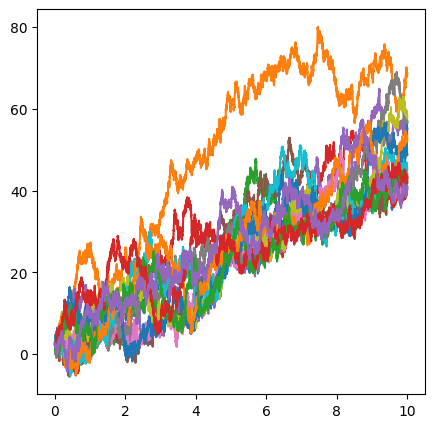

In [47]:
np.random.seed()

# Define base starting variables

T = 10                                  # time interval
N = 10000                               # number of points per path
i = 15                                  # numper of stocks simulated

sigma = np.array([10]*i)                 # rank volatilities
gamma = 5                               # base drift
g = [-1*gamma]*i                        # rank drifts
g[i-1] = (i-1)*gamma
# init_value = [100]*i                    # initial value of stocks
init_value = generate_init_values(i, g, sigma, 10)

delta = 50                              # trading frequency
pi = [1/i]*i                            # portfolio weights
trials = 100                            # number of trials

# simulate and plot the Atlas Model
X = simulate_atlas(T, N, i, init_value, sigma, gamma, g)
time_axis = np.linspace(0, T, N)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for j in range(i):
    plt.plot(time_axis, np.log(X[j]))

excess = continuous_excess_growth_rate(pi, sigma, i)
print(excess)

# df = pd.DataFrame(X)
# filepath = "sample_excel_file.xlsx"
# df.to_excel(filepath, index=False)